In [104]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import time
import numpy as np
import pandas as pd
import re
import nltk
import requests
from furl import furl

from requests.exceptions import ConnectionError
from bs4 import BeautifulSoup

from dotenv import load_dotenv

load_dotenv()

nltk.download('punkt_tab')
nltk.download('stopwords')


df = pd.read_csv("./Listofstartups.csv", encoding='ISO-8859-1')
df.head()


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/hitmonlee/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hitmonlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Incubation Center,Name of the startup,Location of company,Sector,Company profile,Unnamed: 5
0,SIIC IIT KANPUR,E-Trainer Analytics Wizard Pvt ltd,New Delhi,Fit-Tech,"Fitbuddy, a flagship brand under E-Trainer Ana...",NaN
1,SIIC IITK,Invariance Automation Private Limited,"Kanpur, UP",Industrial Automation,Currently we are developing the infrastructure...,NaN
2,"SIIC, IIT Kanpur",Neoperk Technologies Pvt. Ltd.,"Mumbai, Maharashtra",Agri-Tech - Soil Testing,Neoperk makes large scale soil testing extreme...,NaN
3,SIIC IIT KANPUR,WeRehab Technologies Pvt Ltd,Nagpur,Health tech,WeRehab Technologies Pvt Ltd. Is a startup fou...,NaN
4,IIT Kanpur,Arthavedika Tech Pvt Ltd,"Noida, Uttar Pradesh",Fintech,Arthavedika Tech Pvt Ltd is a DIPP certified t...,NaN


In [105]:
from google import genai
from google.genai import types
import os


def summarise_using_llm(text: str) -> str:
    system_prompt = """
    >Hello you need to gernerate a summary like below 2 summaries summary for any suitable big enough query given to you
    >Don't provide salutation, like 'her is what you are asking for' thing like this i don't want i want it to be clean and minimal

    1. "WeRehab Technologies Pvt Ltd. Is a startup founded in Dec 2020, incubated at IIT Kanpur. We are virtual foot health and Physiotherapy clinic. Our product portfolio includes custom orthotic insoles and slippers for improving foot health of our patients and clients. And a smart insole technology for gait analysis of patients, athletes, and fitness enthusiasts who like to be on top of their performance and health.
    Through this technology, we'll make it easier for physios, coaches and other related physicians to early diagnose various conditions such as diabetic foot ulcers, osteoarthritis, muscular imbalances, injury risk, fall risk, etc.

    By using the data from our device, the professionals will be able to give early treatment completely personalized to the person's condition. Apart from that, they will also be able to monitor the progress and alter treatment methods if needed. 

    For athletes: using our smart insole, coaches and the sports medicine team will be able to get the on field data of the athlete which will help them on the biomechanical level. This data will be used to implement training methods that will reduce injury risk and fatigue, and improve performance levels of the athletes as well."
    2. At Hacklab, we develop smart solutions for
    ensuring people safety through digitization.
    Through the increased digitization of machines
    and humans, there is an improvement of not
    only economic, structural, and logistical
    settings of the place but also the safety can be
    decisively optimized.
    By leveraging IoT and AI technologies in our
    products we help companies to eliminate
    or/and isolate the hazards. We use data from
    various sensors on the devices to monitor the
    person's/machine's behavior. In case of
    detection of non-conformity to the SOPs
    (standard operating procedure), the
    management is alerted immediately.
    Our SAFFR AI solution effectively delivers
    'intelligence at the edge' to benefit users with
    real-time analytics and actionable response.
    Real-time response is a necessity for
    safety-critical applications like ours hence most
    of the processing happens on the edge.
    We make
    ? Smart Tags for workers
    ? Tracking devices for heavy machinery
    ? Smart Camera system
    ? Cloud AI
    We have been working with some of the
    largest industries in India and abroad ensuring
    the safety of workers and their operations. Our
    technology helps us establish safety baselines
    for our clients. We provide valuable
    data-points like how close people were getting
    to a hazard and ultimately reducing
    life-threatening events and near-misses

    """

    return talk_to_gemini(text=text,system_prompt=system_prompt)

def talk_to_gemini(text: str,system_prompt: str) -> str:
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))

    response = client.models.generate_content(
        model="gemini-2.5-flash",
        config=types.GenerateContentConfig(
            system_instruction=system_prompt),
        contents=text
    )
    
    return response.text

In [106]:
def is_url(text: str) -> bool:
    if pd.isna(text):
        return False
    return re.match(r"^(https?:\/\/)?(www\.)?([a-zA-Z0-9-]+\.)+[a-zA-Z]{2,}(\/[^\s]*)?$",text.strip())

def sanitize_url(text: str) -> str:
    f = furl(text.strip())
    if not f.scheme:
        f.scheme = "http"
    return f.url.replace("///","//")


def preprocess_company_profile(text: str) -> str:
    return extract_text(text)

def extract_text(url: str) -> str | int:
    try:
        response = requests.get(sanitize_url(url),allow_redirects=True,headers={"User-Agent":"Mozilla/5.0"})
    except ConnectionError:
        return pd.NA


    if response.status_code != 200:
        return pd.NA
    
    content = response.content
    text =  parse_text_from_html(content)

    if len(text) < 100:
        return pd.NA
    return summarise_using_llm(text)


def parse_text_from_html(html: str) -> str:
    soup = BeautifulSoup(html,"html.parser")
    return soup.get_text(strip=True)



    


In [107]:
def preprocess_text(text: str) -> str:
    if pd.isna(text) or text == "-1":
        return text
    
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    
    # remove stopwords
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
    text = " ".join(tokens)
    text = text.lower().strip()
    
    return text


In [ ]:
df.columns = df.columns.str.replace(" ","_").str.lower()


df["processed"] = df["company_profile"].apply(lambda x: preprocess_company_profile(x) if is_url(x) else x)
df["processed"]=  df["processed"].astype(str)
df["processed"] = df["processed"].apply(lambda x: preprocess_text(x))

mask = (
    df["processed"].astype(str).str.isnumeric() |  
    df["processed"].isna() |                     
    df["processed"].str.lower().isin(["na", "nan"])        
)

df.loc[mask, "processed"] = "na"


In [109]:
df.to_csv("./processed_company_profile.csv")

In [110]:
# TF-IDF Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=2, max_df=0.95)
X = vectorizer.fit_transform(df['processed']).toarray()

In [ ]:
# Sentence Transformer

from sentence_transformers import SentenceTransformer

st = time.time()

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
df['encode_transforemers'] = df['processed'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))


X_transformers = np.vstack(df['encode_transforemers'])

In [ ]:
# GloVe

from torchtext.vocab import GloVe

embeddings = GloVe(name='6B', dim=100)

# Set the maximum sentence length and embedding dimension
max_length = 100 
embedding_dim = 100

# define a function to convert a sentence to a fixed-size vector using GloVe embeddings
def sentence_embedding(sentence):
    words = sentence.split()
    num_words = min(len(words), max_length)
    embedding_sentence = np.zeros((max_length, embedding_dim))
    
    for i in range(num_words):
        word = words[i]
        if word in embeddings.stoi:
            embedding_sentence[i] = embeddings.vectors[embeddings.stoi[word]]
            
    return embedding_sentence.flatten()

df['encode_glove'] = df['processed'].apply(lambda sentence: sentence_embedding(sentence))
X_glove = np.vstack(df['encode_glove'])

/tmp/ipykernel_5011/2997349109.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  embedding_sentence[i] = embeddings.vectors[embeddings.stoi[word]]


In [ ]:
# BERT-cls

from transformers import BertTokenizer
from transformers import BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_cls_sentence(sentence):
    # Tokenize input sentence and convert to tensor
    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=512)])

    # Pass input through BERT model and extract embeddings for [CLS] token
    with torch.no_grad():
        outputs = model(input_ids)
        cls_embedding = outputs[0][:, 0, :]
    
    return cls_embedding.flatten()

In [ ]:
st = time.time()

df['cls_bert'] = df['processed'].apply(lambda sentence: get_cls_sentence(sentence))

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))

X_cls_bert = np.vstack(df['cls_bert'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Elapsed time: 12.28 seconds


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

def eval_cluster(embeddings):
    kmeans = KMeans(n_clusters=5, random_state=42,n_init=10,init="k-means++")
    y_pred = kmeans.fit_predict(embeddings)

    
    # Evaluate the performance using ARI, NMI, and FMI
    ari = adjusted_rand_score(df["class"], y_pred)
    nmi = normalized_mutual_info_score(df["class"], y_pred)
    fmi = fowlkes_mallows_score(df["class"], y_pred)

    # Print Metrics scores
    print("Adjusted Rand Index (ARI): {:.3f}".format(ari))
    print("Normalized Mutual Information (NMI): {:.3f}".format(nmi))
    print("Fowlkes-Mallows Index (FMI): {:.3f}".format(fmi))


In [ ]:
from sklearn.decomposition import PCA

def dimension_reduction(embedding, method):

    pca = PCA(n_components=2, random_state=42)

    pca_vecs = pca.fit_transform(embedding)

    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    
    df[f'x0_{method}'] = x0 
    df[f'x1_{method}'] = x1

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

def plot_pca(x0_name, x1_name, cluster_name, method):

    plt.figure(figsize=(12, 7))

    plt.title(f"TF-IDF + KMeans StartUp in India clustering with {method}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    sns.scatterplot(data=df, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    plt.show()

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
def map_cluster_to_truth(df: pd.DataFrame,cluster_col: pd.Series,truth_col: pd.Series) -> pd.Series:
    
    cluster_to_label_map = df.groupby(cluster_col)[truth_col].agg(lambda x: x.mode().iloc[0]).to_dict()
    predicted_labels = df[cluster_col].map(cluster_to_label_map)

    return predicted_labels


Accuracy for tfidf: 0.3824
Adjusted Rand Index (ARI): 0.012
Normalized Mutual Information (NMI): 0.051
Fowlkes-Mallows Index (FMI): 0.252


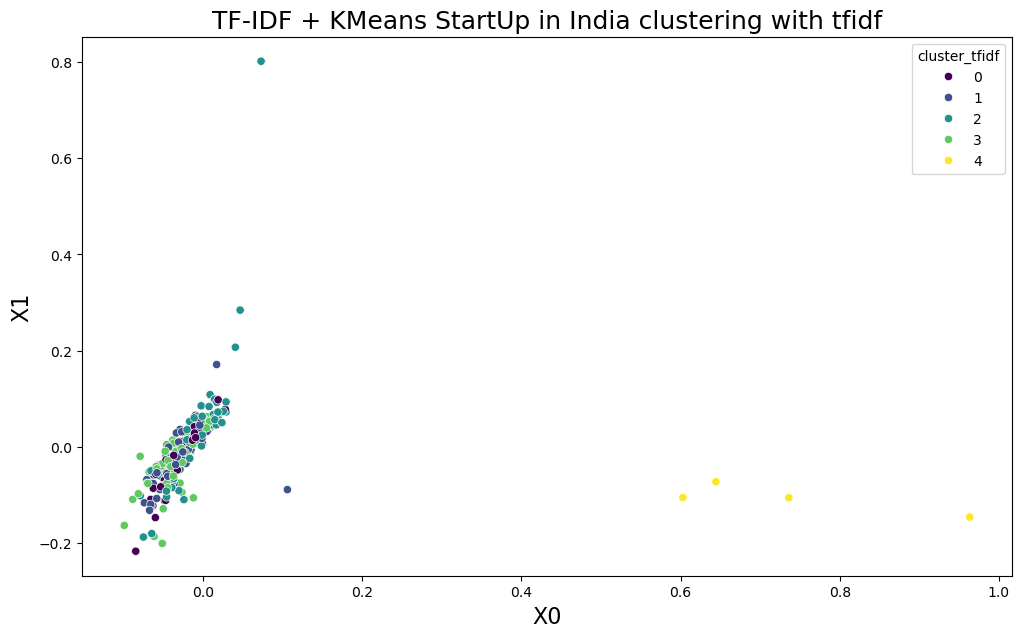

Accuracy for transformers: 0.4160
Adjusted Rand Index (ARI): 0.091
Normalized Mutual Information (NMI): 0.167
Fowlkes-Mallows Index (FMI): 0.347


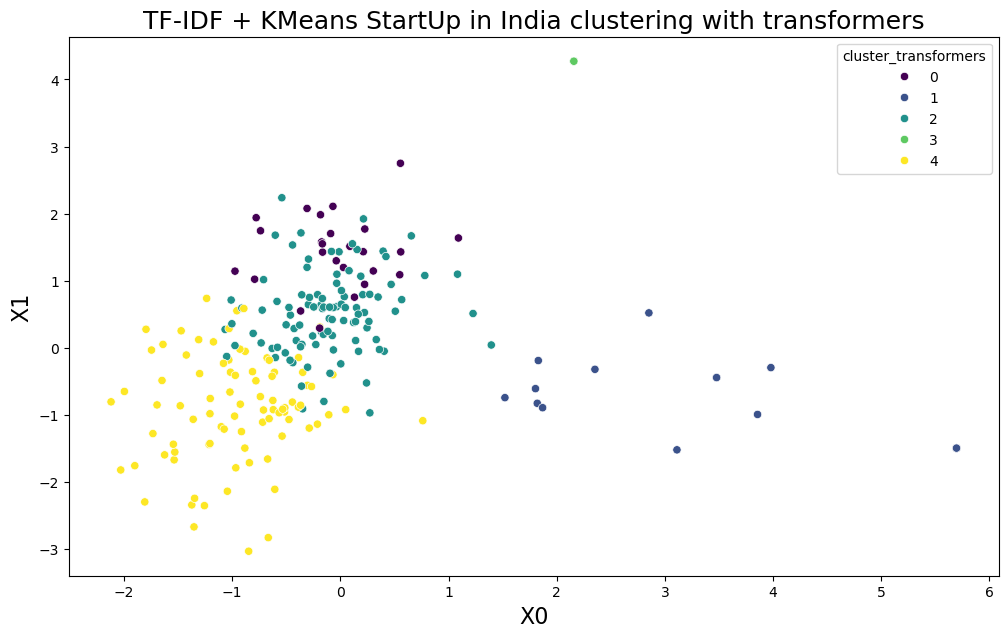

Accuracy for glove: 0.3529
Adjusted Rand Index (ARI): 0.019
Normalized Mutual Information (NMI): 0.046
Fowlkes-Mallows Index (FMI): 0.430


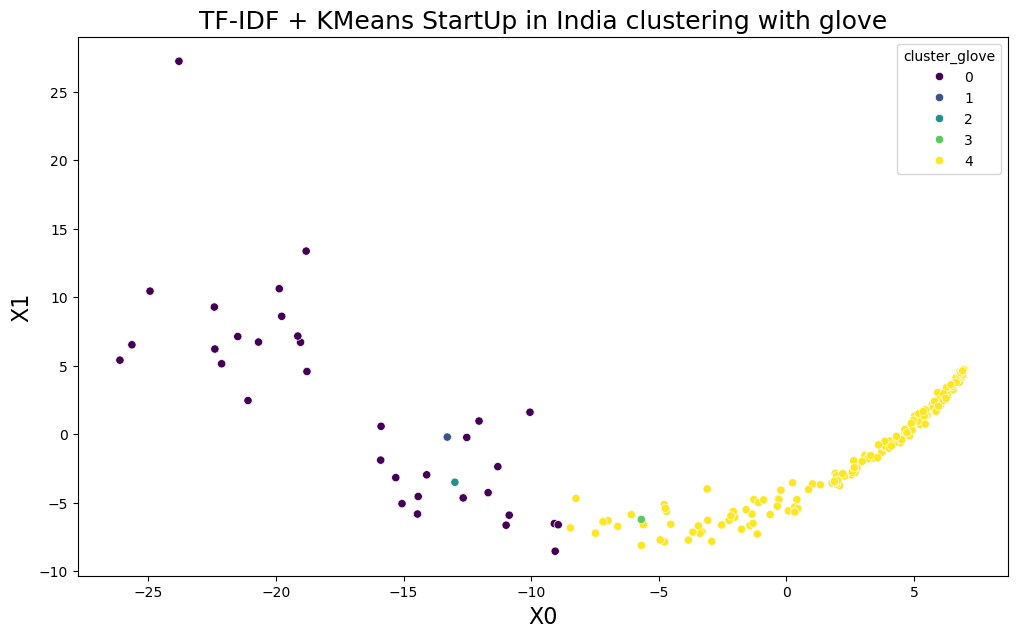

Accuracy for Bert-CLS: 0.3487
Adjusted Rand Index (ARI): 0.005
Normalized Mutual Information (NMI): 0.054
Fowlkes-Mallows Index (FMI): 0.252


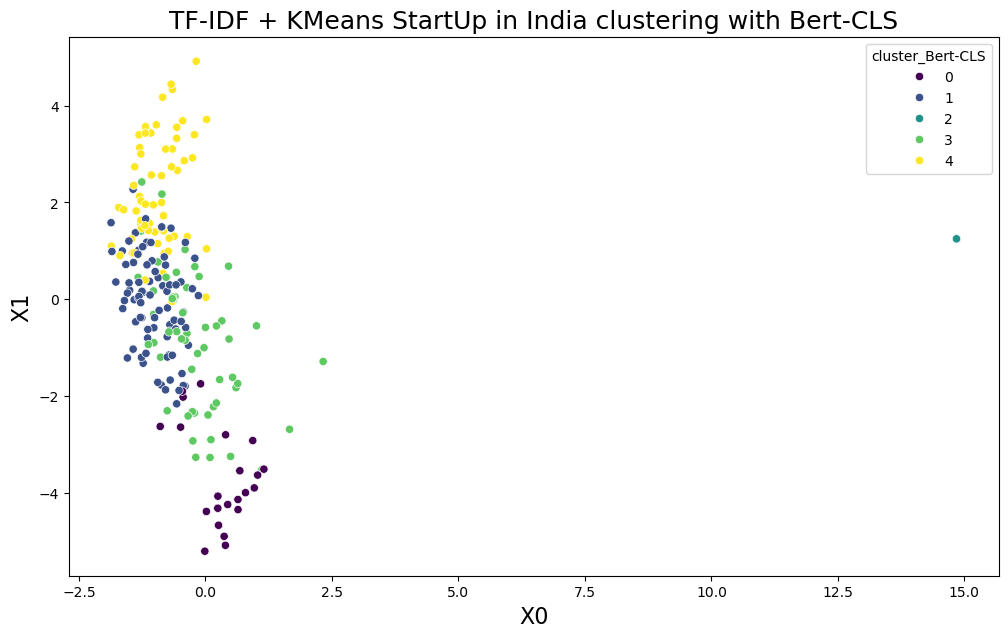

In [ ]:
from sklearn.metrics import accuracy_score

source_of_truth_col = "class"

for embedding_and_method in [(X, 'tfidf'), (X_transformers, 'transformers'), (X_glove, 'glove'), (X_cls_bert, 'Bert-CLS')]:
    embedding, method = embedding_and_method[0], embedding_and_method[1]
    
    
    kmeans = KMeans(n_clusters=5, random_state=42,n_init=10,init="k-means++")
    kmeans.fit(embedding)
    
    clusters = kmeans.labels_
    
    clusters_result_name = f'cluster_{method}'
    df[clusters_result_name] = clusters
    
    predicted_label_name = f'predicted_label_{method}'
    df[predicted_label_name] = map_cluster_to_truth(df, clusters_result_name, source_of_truth_col)
    
    accuracy = accuracy_score(df[source_of_truth_col], df[predicted_label_name])
    print(f"Accuracy for {method}: {accuracy:.4f}")
    

    eval_cluster(embedding)
    dimension_reduction(embedding, method)
    plot_pca(f'x0_{method}', f'x1_{method}', cluster_name=clusters_result_name, method=method)



In [ ]:
df.columns

Index(['incubation_center', 'name_of_the_startup', 'location_of_company',
       'sector', 'company_profile', 'sector_normalized', 'sector_group',
       'class', 'unnamed:_8', 'processed', 'encode_transforemers',
       'encode_glove', 'cls_bert', 'cluster_tfidf', 'predicted_label_tfidf',
       'x0_tfidf', 'x1_tfidf', 'cluster_transformers',
       'predicted_label_transformers', 'x0_transformers', 'x1_transformers',
       'cluster_glove', 'predicted_label_glove', 'x0_glove', 'x1_glove',
       'cluster_Bert-CLS', 'predicted_label_Bert-CLS', 'x0_Bert-CLS',
       'x1_Bert-CLS'],
      dtype='object')

In [ ]:
df.loc[:,["sector_group","class","cluster_tfidf","cluster_transformers","cluster_glove","cluster_Bert-CLS"]].to_csv("/tmp/work.csv")

In [ ]:
show_df = pd.read_csv("/tmp/work.csv")
show_df.drop(columns=["Unnamed: 0","sector_group"],inplace=True)

show_df

,class,cluster_tfidf,cluster_transformers,cluster_glove,cluster_Bert-CLS
0,C,3,2,4,1
1,D,0,4,4,3
2,A,1,4,0,4
3,C,3,2,0,4
4,D,3,2,0,4
...,...,...,...,...,...
233,D,2,2,4,4
234,E,3,4,4,1
235,E,1,4,4,1
236,C,0,4,4,3


In [ ]:
with pd.ExcelWriter("/tmp/detail_show.xlsx") as writter:
    for col in show_df.columns.drop("class"):

        result = show_df.groupby("class")[col].value_counts()

        result.to_excel(writter,sheet_name=f"{col}_counts")

In [ ]:
show_df.groupby("class").value_counts().to_excel("/tmp/detail.xlsx")

In [ ]:
df.sector = df.sector.value_counts()
